In [34]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import numpy as np
from sklearn.preprocessing import StandardScaler

X = np.load('../Language_digits/X.npy')
Y = np.load('../Language_digits/Y.npy')

X.shape
X
Y.shape
Y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

Sign-language-digits-dataset is formed of 2062 images, each 64x64.

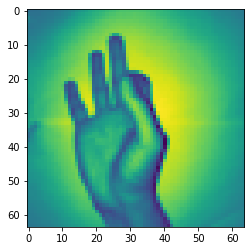

In [6]:
plt.imshow(X[0])

the Y dataset here gives us the labels for these images, 
it's kind of weirdly ordered and this image represents the number

In [7]:
9 - np.argmax(Y[0])

9

In [54]:
5 - np.argmax(Y[0])

5

To start with let's flatten our data into 2062 4096 dim vectors and split the dataset into training and testing sets.

In [8]:
X_flat = np.array(X).reshape((2062, 64*64))

X_train, X_test, y_train, y_test = train_test_split(X_flat, Y, test_size=0.3, random_state=42)

To demonstrate how dimensionality reduction can improve the results of a model we need a model. Here is a very basic, fully connected neural net
This is deliberately not a great model and I'm not going to tune the hyper-parameters. We only need this as a benchmark for later

In [9]:
clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20, 20, 20), random_state=1)
clf.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=1, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [10]:
y_hat = clf.predict(X_test)

print("accuracy: " + str(accuracy_score(y_test, y_hat)))

accuracy: 0.3360258481421648


As you can see, this is a pretty poor model, only achieving ~30% overall accuracy on the test set.
We're now goint to reduce the dimension of our training data and then retrain what we have.
The objective here is going to be to reduce the number of dimensions of the image, but before we do that we need to decide what we want to reduce it to. To do that we're going to try and find the number of dimensions that keeps 95% of the variance of the original images.


In [11]:
pca_dims = PCA()
pca_dims.fit(X_train)
cumsum = np.cumsum(pca_dims.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [12]:
d

292

Wow - so we've gone from 4096 dimensions to just 292! But how good is this actually?

Let's train PCA on our training set and transform the data, then print out an example


In [14]:
pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)
print("reduced shape: " + str(X_reduced.shape))
print("recovered shape: " + str(X_recovered.shape))

reduced shape: (1443, 292)
recovered shape: (1443, 4096)


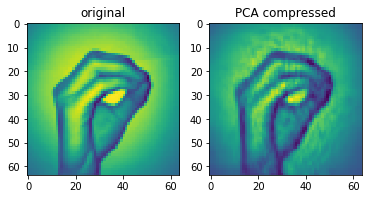

In [15]:
f = plt.figure()
f.add_subplot(1,2, 1)
plt.title("original")
plt.imshow(X_train[0].reshape((64,64)))
f.add_subplot(1,2, 2)

plt.title("PCA compressed")
plt.imshow(X_recovered[0].reshape((64,64)))
plt.show(block=True)

You can see it's far from perfect, but it's still clear what shape the hand is making

Let's retrain our model with the dimensionally reduced training data:


In [16]:
clf_reduced = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(20, 20, 20))
clf_reduced.fit(X_reduced, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20, 20, 20), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

In [17]:
X_test_reduced = pca.transform(X_test)
y_hat_reduced = clf_reduced.predict(X_test_reduced)

print("accuracy: " + str(accuracy_score(y_test, y_hat_reduced)))

accuracy: 0.6607431340872375


And as you can see we've taken this simple model from ~30% accuracy on the test set to ~65%

In [42]:
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_reduced)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf

,principal component 1,principal component 2
0,-3.054748,0.438076
1,1.038444,4.973876
2,-1.517717,5.229355
3,0.705060,-0.568528
4,-3.298370,1.071861
...,...,...
1438,-0.218291,2.581763
1439,0.565556,-1.829194
1440,0.106717,-1.666067
1441,-1.064843,3.844232


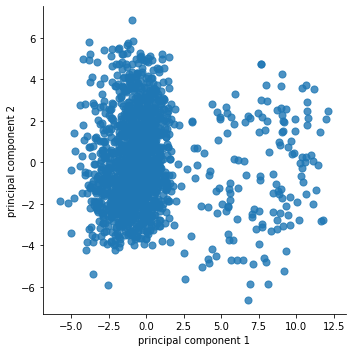

In [43]:
import seaborn as sns
sns.lmplot( x='principal component 1', y='principal component 2',
  data=principalDf, 
  fit_reg=False, 
  legend=True,
  scatter_kws={"s": 50}, colors) # specify the point size

In [44]:
df_100 = principalDf.head(100)

In [61]:
def plot_digits_colidx(X, Y):
    plt.figure(figsize=(10,10))
    plt.plot([5, 2, 11])
    for i in col_idx:
        ax = plt.subplot(5, 2, i+1)
        ax.set_title("Column_idx: " + str(i))
        plt.axis('off')
        plt.imshow(X[np.argwhere(Y[:,i]==1)[0][0],:], cmap='gray')

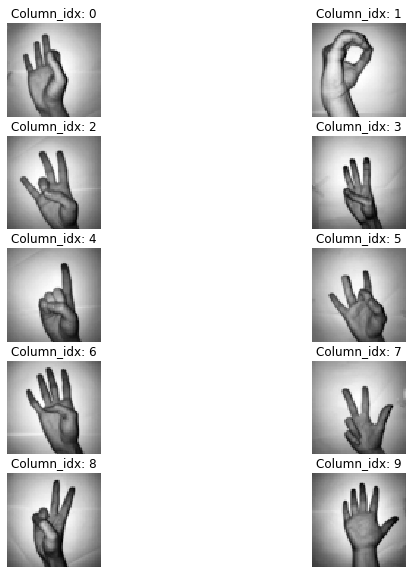

In [62]:
N_classes = Y.shape[1]
col_idx = [i for i in range(N_classes)]
plot_digits_colidx(X, Y)

In [63]:
#dictionary that handles the column index - digit relatinship
colidx_digit = {0: 9,
                1: 0,
                2: 7,
                3: 6,
                4: 1,
                5: 8,
                6: 4,
                7: 3,
                8: 2,
                9: 5}

#digit - column index relationship dictionary
digit_colidx = {v: k for k, v in colidx_digit.items()}

In [64]:
#create empty matrix
Y_ordered = np.zeros(Y.shape)
#fill the matrix so that the columns index also corresponds to the digit
for i in range(N_classes):
    Y_ordered[:, i] = Y[:, digit_colidx[i]]

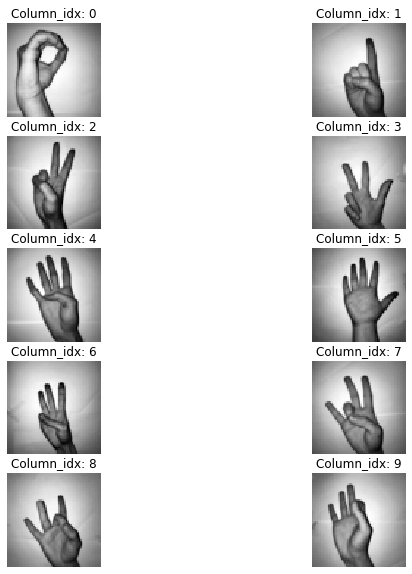

In [65]:
plot_digits_colidx(X, Y_ordered)



In [66]:
Y.sum(axis=0)

array([204., 205., 206., 207., 206., 208., 207., 206., 206., 207.])

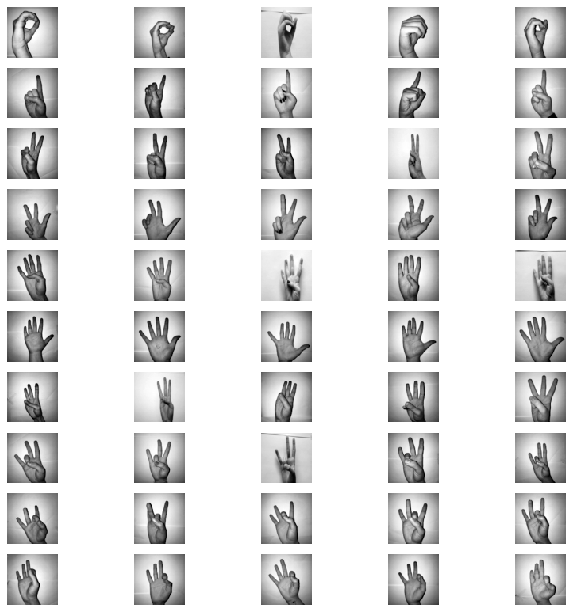

In [67]:
#N images per row
N_im_lab = 5
plt.figure(figsize=(11,11))
plt.plot([N_classes, N_im_lab, (N_im_lab * N_classes) + 1])

#for every label
for lab in range(N_classes):
    #show N_im_lab first samples
    for i in range(N_im_lab):
        ax = plt.subplot(N_classes, N_im_lab, 1 + (i + (lab*N_im_lab)))
        plt.axis('off')
        plt.imshow(X[np.argwhere(Y_ordered[:,lab]==1)[i][0],:], cmap='gray')

In [99]:
from sklearn.decomposition import PCA
import pandas as pd
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X_train)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf['Label']=pd.DataFrame("L"+str(y) for y in y_train)


for i, v in enumerate(y_train):
    principalDf.loc[i, 'Label'] = np.where(v == 1)[0][0]

principalDf


,principal component 1,principal component 2,Label
0,-3.054667,0.438100,1
1,1.038534,4.973894,4
2,-1.517629,5.229406,1
3,0.705152,-0.568558,4
4,-3.298281,1.071835,9
...,...,...,...
1438,-0.218201,2.581666,7
1439,0.565647,-1.829142,5
1440,0.106808,-1.666029,5
1441,-1.064753,3.844245,6


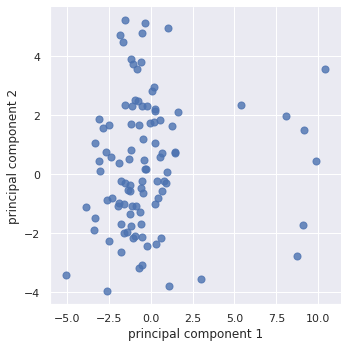

In [105]:
import seaborn as sns
sns.lmplot( x='principal component 1', y='principal component 2',
  data=df_100, 
  fit_reg=False, 
  legend=True,
  scatter_kws={"s": 50}) # specify the point size

In [72]:
np.argmax(Y[1442])

6

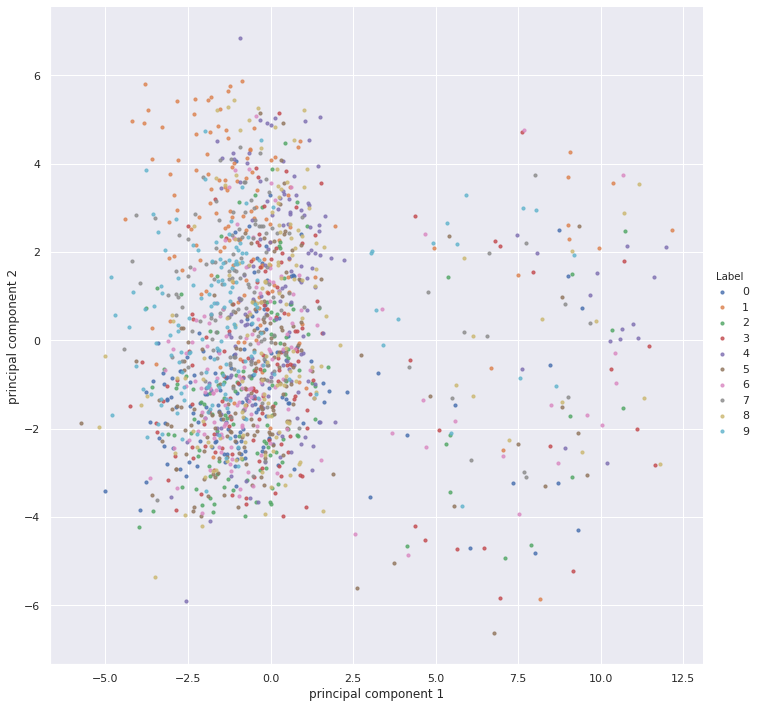

In [101]:
import seaborn as sns
sns.lmplot( x='principal component 1', y='principal component 2',
  data=principalDf, 
  fit_reg=False, 
  legend=True, hue='Label', height=10,
  scatter_kws={"s": 10}) # specify the point size